# Support Vector Machines

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
from enum import Enum 
plt.style.use('seaborn')
%matplotlib inline
from pandas_datareader import data as web

# 1. Feature Extraction and Pre Processing

### 1.1 Utility methods and classes for feature extraction

Feature class containing  possible features which are supported

In [2]:
class Feature(Enum):
    OHLC           = 1
    LAGGED_RETURNS = 2
    SMA_PRICE      = 3
    SMA_VAR        = 4
    RSI            = 5
    MACD           = 6
    EWMA_PRICE     = 7
    EWMA_VAR       = 8
    VAR            = 9

### 1.2 Gaussian method
Gaussian method to normalize and transform the data to zero mean

In [3]:
def gaussian(xa):
    x = xa.copy()
    mean = x.mean()
    std = x.std()
    return (x - mean) / std, mean, std

## 1.3 RSI Feature

In [4]:
def RSI(series, period, normalize = True):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
 #pd.stats.moments.ewma(d, com=period-1, adjust=False)

 rs = u.ewm(span=period-1, adjust=False).mean() / d.ewm(span=period-1, adjust=False).mean()

 rsi = 100 - 100 / (1 + rs)
 
 if normalize:
  rsi, mean, std  = gaussian(rsi)
    
 return rsi

## 1.4 MACD Feature

In [5]:
def MACD(series, period, normalize = True):
 exp1 = series.ewm(span=12, adjust=False).mean()
 exp2 = series.ewm(span=26, adjust=False).mean()
 macd = exp1-exp2
 
 if normalize:
  macd, mean, std = gaussian(macd)

 return macd

In [6]:
def get_data(features, normalize = True):
    # Download the histo market data
    # Extract the Features
    # Returns Featurs and columns
    data = pd.DataFrame(web.DataReader('AMZN', data_source='yahoo')[['High', 'Low', 'Open', 'Close']])
    data.columns = ['h', 'l', 'o', 'c']
    cols = []
    
    # The log return
    data['returns'] = np.log(data['c'] / data['c'].shift(1))
    # Return Sign
    data['d'] = np.where(data['returns'] > 0, 1, -1)
    
    LAGS = 5
    if Feature.OHLC in features:
        data['h-l'] = data['h'] - data['l']
        data['c-o'] = data['c'] - data['o']
        cols.append('c-o')
        cols.append('h-l')
    if Feature.LAGGED_RETURNS in features:
        for lag in range(1, LAGS+1):
            col = 'ret_%d' % lag
            data[col] = data['returns'].shift(lag)
            cols.append(col)
    if Feature.SMA_PRICE in features: 
        data['sma10'] = data['c'].rolling(10).mean() # Simple moving average
        data['sma25'] = data['c'].rolling(25).mean()
        cols.append('sma10')
        cols.append('sma25')
    if Feature.SMA_VAR in features: 
        data['var10'] = data['c'].rolling(10).std() # Simple moving average
        data['var25'] = data['c'].rolling(25).std()
        cols.append('var10')
        cols.append('var25')
    if Feature.RSI in features: 
        data['rsi'] = RSI(data['c'], 10, False)
        cols.append('rsi')
    if Feature.MACD in features: 
        data['macd'] = MACD(data['c'], 10, False)
        cols.append('macd')
    if Feature.EWMA_PRICE in features: 
        data['ewma'] = data['c'].ewm(span=20, adjust=False).mean()
        cols.append('ewma')
    if Feature.EWMA_VAR in features: 
        data['ewmstd'] = data['c'].ewm(span=20, adjust=False).std()
        cols.append('ewmstd')
    
  
    data.dropna(inplace=True)
    #print(data.head())
    # Get the gaussian of all the values - so that we have normalized the data.
    if normalize:
       for col in cols:
           data[col], mean, std = gaussian(data[col])
        
    return data, cols

In [7]:
data, cols = get_data(
    [Feature.OHLC,  
     Feature.LAGGED_RETURNS,  
     Feature.SMA_PRICE,  
     Feature.SMA_VAR,  
     Feature.RSI,  
     Feature.MACD, 
     Feature.EWMA_PRICE,  
     Feature.EWMA_VAR])

In [8]:
cols

['c-o',
 'h-l',
 'ret_1',
 'ret_2',
 'ret_3',
 'ret_4',
 'ret_5',
 'sma10',
 'sma25',
 'var10',
 'var25',
 'rsi',
 'macd',
 'ewma',
 'ewmstd']

## 2. SVM Prediction

SVM Classifier provides the end result (probability transition for PositiveReturn/NegativeReturn) which is the same as the
Logistic Regression. However, SVM does not have regression coefficients, it can output <b>SVM_SVC.supportvectors</b> attribute.

### 2.1 Model Prediction on trained data set

In [9]:
from sklearn.svm import SVC

In [10]:
# Run Support Vector Classification
C=1e1
SVM_SVC = SVC(C=C, probability=True)
SVM_SVC.fit(data[cols], data['d']) ###FITTING DONE HERE
SVM_SVC.get_params

<bound method BaseEstimator.get_params of SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>

In [11]:
SVM_SVC.predict_proba(data[cols])

array([[0.00651253, 0.99348747],
       [0.91116695, 0.08883305],
       [0.44503326, 0.55496674],
       ...,
       [0.01800545, 0.98199455],
       [0.93148023, 0.06851977],
       [0.16005343, 0.83994657]])

In [12]:
svmScore = SVM_SVC.score(data[cols], data['d'])
svmScore

0.9380791912384162

<b>Summary:</b>

In [13]:
print("The SVN predict score on Train data set is {}".format(svmScore))

The SVN predict score on Train data set is 0.9380791912384162


### 2.1 Model Prediction on test data set

The data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [15]:
from sklearn import model_selection
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=False)

In [16]:
train = train.copy()
test = test.copy()

In [17]:
print("Train count {}, Test count {}".format(len(train), len(test)))

Train count 1899, Test count 475


In [18]:
# Run Support Vector Classification
C=1e1
SVM_SVC_test = SVC(C=C, probability=True)
SVM_SVC_test.fit(train[cols], train['d']) ###FITTING DONE HERE
SVM_SVC_test.get_params

<bound method BaseEstimator.get_params of SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>

In [19]:
testPredictProba = SVM_SVC_test.predict_proba(test[cols])

In [20]:
svmTestScore = SVM_SVC_test.score(test[cols], test['d'])
svmTestScore

0.7115789473684211

<b>Summary:</b>

In [21]:
print("The SVN predict score on Test data set is {}".format(svmTestScore))

The SVN predict score on Test data set is 0.7115789473684211


## 3. Precision Recall

In [22]:
from sklearn.metrics import classification_report

In [23]:
svmScore = SVM_SVC.score(data[cols], data['d'])

In [24]:
data['p'] = SVM_SVC.predict(data[cols])

In [25]:
print("The SVN predict score on Train data set is {}".format(svmScore))

The SVN predict score on Train data set is 0.9380791912384162


In [26]:
print(classification_report(data['d'], data['p']))

             precision    recall  f1-score   support

         -1       0.94      0.92      0.93      1104
          1       0.93      0.95      0.94      1270

avg / total       0.94      0.94      0.94      2374



## 4. Confusion Matrix

Allows to look into accuracy of prediction within each class. TO BE READ ON DIAGONAL (visualisation
below)
<br>
Predicted NegativeReturns that were actually NegativeReturns (-1):
<br>
Predicted PositiveReturns that were actually PositiveReturns (1):
<br>

In [27]:
from sklearn.metrics import confusion_matrix


In [28]:
confusion_matrix = confusion_matrix(data['d'], data['p'], labels=[-1,1])
print(confusion_matrix)

[[1019   85]
 [  62 1208]]


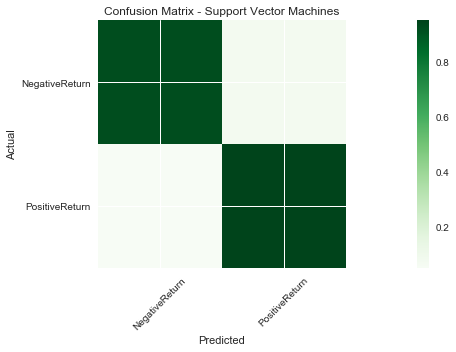

In [29]:
# function for plotting confusion matrix
def plot_cm(cm, target_names, title,
    cmap=plt.cm.Greens):
    cm_norm = cm * 1. / cm.sum(axis=1)[:, np.newaxis] # standardize the confusion matrix
    plt.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    ticks = np.arange(len(target_names))
    plt.xticks(ticks, target_names, rotation=45)
    plt.yticks(ticks, target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()

plt.clf
plt.figure(figsize=(20, 5), facecolor='w')
plt.subplot(111)
plot_cm(confusion_matrix, ['NegativeReturn','PositiveReturn'], 'Confusion Matrix - Support Vector Machines')
plt.show()

<b>Summary:</b>

# 5 K-Fold 

In [30]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [31]:
kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=False) # RandomState is the seed used by the RNG
print(kfold)


KFold(n_splits=5, random_state=7, shuffle=False)


In [32]:
crossval = model_selection.cross_val_score(SVM_SVC, data[cols], data['d'], cv=kfold, scoring='accuracy')

<b>K-Fold Summary</b>

In [33]:
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy

5-fold crossvalidation accuracy: 0.8496


# 6. SVM_SVC.support_vectors

Support Vector Machines (SVMs) provide a powerful method for supervised learning. In this task,
the hyperplane might be not of high quality (separating survivals from defaults) or not well-defined,
however, transition probabilities output is credible.<br><br>

Support Vectors are difficult to present, effectively they give a hyperplane -- in 2D projection it is a
line that separates classes.



In [34]:
X_Features_2D = data[cols].loc[:,['rsi', 'macd']]

In [35]:
X_Features_2D.head()

rsi      macd
Date                          
2010-02-05 -1.068920 -0.580821
2010-02-08 -1.177733 -0.584418
2010-02-09 -0.702773 -0.578203
2010-02-10 -0.894808 -0.574073
2010-02-11  0.078516 -0.553985

In [36]:
Y_Response = data.loc[:,['d']]

In [37]:
#Y_Response.head()

In [38]:
#C=1e5 #To soften the margins try much smaller values, such as C=1
C=1
SVM_2D = SVC(C=C, probability=True) #kernel='linear'
SVM_2D.fit(X_Features_2D, Y_Response['d'])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
#X_Features_2D.loc[:, 'm_lag_10']
#Y_Response.head()
#Y_Response.loc[:, 'd']

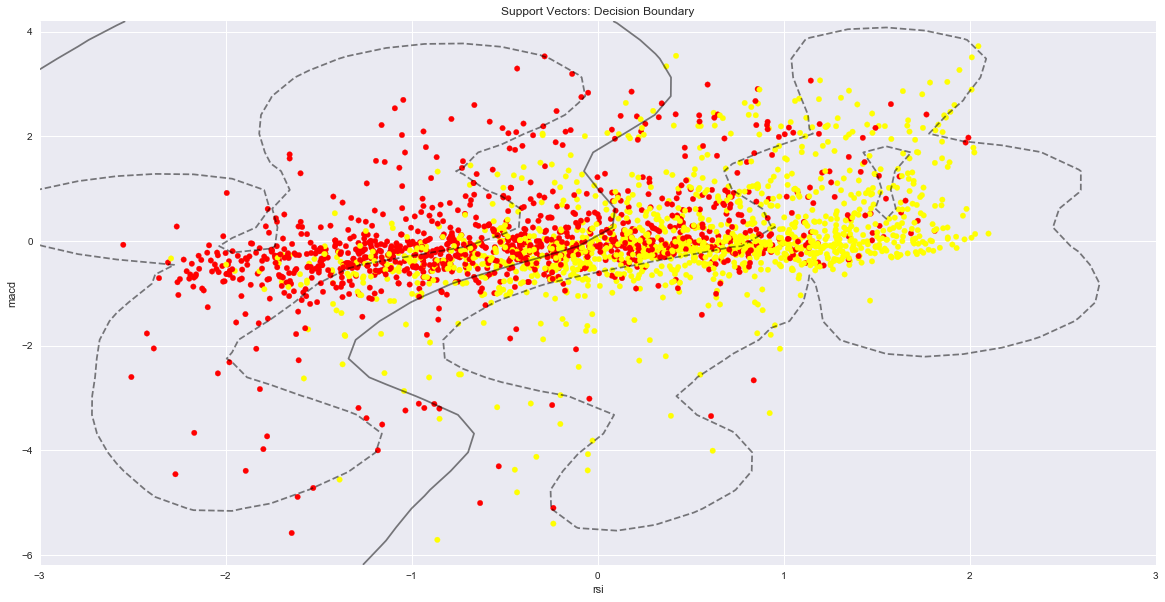

In [40]:
# Plot the decision function for a 2D SVC
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xlim = (-3, 3) #Correction to see the entire decision boundary for SVM_2D based on X_Features.loc[:,['RE/TA', 'ME/TL']]
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
                levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Below only works with 2D features
plt.clf
plt.figure(figsize=(20, 10)) #facecolor='w'
plt.scatter(X_Features_2D.loc[:, 'rsi'], X_Features_2D.loc[:, 'macd'], c=Y_Response.loc[:, 'd'], s=30, cmap='autumn')
plot_svc_decision_function(SVM_2D);
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('rsi')
plt.ylabel('macd')
plt.title('Support Vectors: Decision Boundary')
#plt.legend(loc="lower right")
#plt.savefig('plot_name') #Save into file
plt.show()

In [41]:
SVM_2D.score(X_Features_2D, Y_Response['d'])

0.7089300758213984

In [42]:
# Let's plot WITHOUT data, support vectors only
plt.clf
plt.figure(figsize=(20, 10)) #facecolor='w'
ax = plt.gca()
xlim = (-3, 3)
ylim = (-4, 2)
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = SVM_2D.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(SVM_2D.support_vectors_[:, 0], SVM_2D.support_vectors_[:, 1], s=50, linewidth=1, facecolors='none')
# plot support vectors
ax.scatter(SVM_2D.support_vectors_[:, 0], SVM_2D.support_vectors_[:, 1])
plt.show()

In [43]:
svm2DTestScore = SVM_2D.score(X_Features_2D, Y_Response['d'])
svm2DTestScore

0.7089300758213984

<b>Summary:</b>

In [44]:
print("The SVN predict score on Test data set for (rsi & macd) feature is {}".format(svm2DTestScore))

The SVN predict score on Test data set for (rsi & macd) feature is 0.7089300758213984


# 7. Score Metric for different values of C

<b> a) Softening of the margin by modifying the parameter C=1e5.</b> <br>
For the large , the margin is hard, and points cannot lie in it. <br>
For smaller , the margin is softer, and can grow to encompass some points. <br>
The small value of allows the margins to be calculated using all more data in the areas close. The large
value of basically tells our model that we do not have that much faith in our data’s distribution, and will
only consider points close / on line of separation.

In [45]:
C = [1e2, 1e5, 1e10]

for c in C:
    svmlocal = SVC(C=c, probability=True)
    svmlocal.fit(train[cols], train['d']) ###FITTING DONE HERE    
    print("Score for C={} is {}".format(c, svmlocal.score(test[cols], test['d'])))

Score for C=100.0 is 0.6736842105263158
Score for C=100000.0 is 0.6694736842105263
Score for C=10000000000.0 is 0.6694736842105263


<b>b) Trying various kernels</b>
to transform the data -- you can choose as input parameter, part of the classifier implementation.<br>
If default parameters do not make classification -- you need to change the kernel.

In [46]:
from sklearn import svm

In [47]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1e5 # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
            svm.LinearSVC(C=C),
            svm.SVC(kernel='rbf', gamma=0.7, C=C),
            svm.SVC(kernel='poly', degree=3, C=C))

# title for the plots
titles = ('SVC with linear kernel',
'LinearSVC (linear kernel)',
'SVC with RBF kernel',
'SVC with polynomial (degree 3) kernel')
models = (classifier.fit(train[cols], train['d']) for classifier in models)
for model, title in zip(models, titles):
    print('{} Score={}'.format(title, model.score(test[cols],test['d'])))

SVC with linear kernel Score=0.8526315789473684
LinearSVC (linear kernel) Score=0.8
SVC with RBF kernel Score=0.6252631578947369
SVC with polynomial (degree 3) kernel Score=0.7936842105263158
